In [28]:
#Classification of MNIST dataset 
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats
using MLDatasets
using IterTools #Only for plots, not for program

#include("hmc_mod.jl")
#include("helper_functions.jl")
include("proposals.jl")
include("mnist.jl")
include("utils.jl");

In [29]:
#Load the MNIST Data
num_samples = 10
x_train, y_train = load_mnist_train_set()
x_test, y_test = load_mnist_test_set()

x, y = balanced_set(x_train,y_train,num_samples,2);

#Test Set
x_test, y_test = balanced_set(x_test,y_test,num_samples);

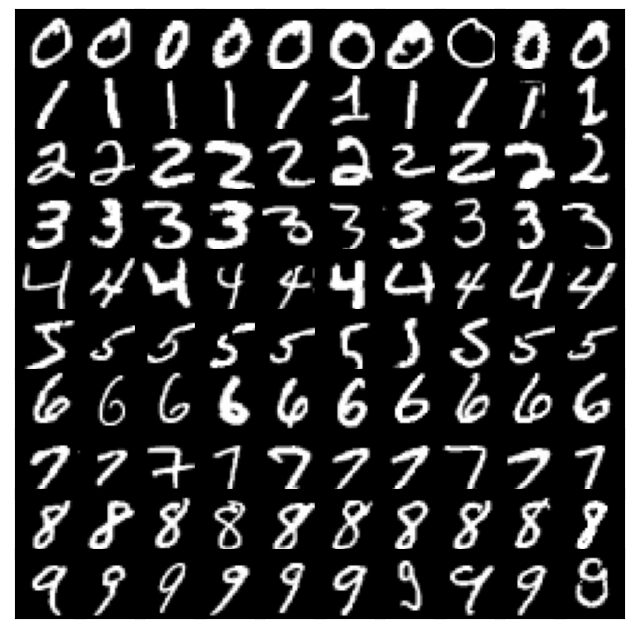

In [30]:
#Visualize Samples
x_reshaped = reshape_x(x)

nrow, ncol = 10,num_samples 
fig = figure("plot_mnist",figsize=(6,6))
for (i, (c, r)) in enumerate(Iterators.product(1:ncol, 1:nrow))
    subplot(nrow, ncol, i)
    imshow(x_reshaped[:,:,i]', cmap="gray")
    ax = gca()
    ax.xaxis.set_visible(false)
    ax.yaxis.set_visible(false)
end;
tight_layout(w_pad=-1, h_pad=-1, pad=-0.5);

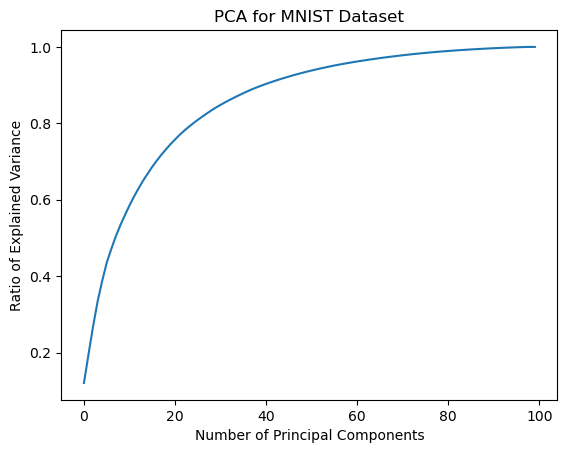

In [31]:
#Run PCA to lower dimensionality of MNIST
vars = []
x = transpose(x)
for i=1:100    
    MNIST_PCA = fit(PCA, x, maxoutdim=i, pratio=1.0)
    push!(vars,MNIST_PCA.tprinvar/MNIST_PCA.tvar)
end
plot(vars)
plt.title("PCA for MNIST Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Ratio of Explained Variance");

In [61]:
#Get PCA Transform for x
dims = 50
x_pca = fit(PCA,x,maxoutdim=dims)
xt = transform(x_pca,x)

#Testing PCA Transform
xz = transform(x_pca,transpose(x_test));

In [62]:
#One-Hot Encode Y
yt = Flux.onehotbatch(y,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);

#Test Set
yz = y_test
yzt = Flux.onehotbatch(yz,[:1,:2,:3,:4,:5,:6,:7,:8,:9,:10]);

In [63]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"

#Data hyperparameters
n = num_samples #Number of samples
c = 10 #Number of classes
d = dims #Input dimension
N = n*c #Total samples

#Network hyperparameters
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape

#Node hyperparameters
k_range = 10 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]

#NUTS
Δ_max = 1000;

In [64]:
#New Softmax
function softmax_(arr::AbstractArray)
    ex = mapslices(x -> exp.(x),arr,dims=1)
    rows, cols = size(arr)
    val = similar(ex)
    for i in 1:cols
        s = sum(ex[:,i])
        for j in 1:rows
            val[j,i] = ex[j,i]/s
        end
    end
    return val
end;

In [65]:
#Bayesian Neural Net
function G(x, trace)
    activation = relu
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], c, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], c)
    
    nn_out = Dense(Wₒ, bₒ)
    x = nn_out(x)
    
    return softmax_(x)
end;

In [66]:
xt

50×100 Array{Float64,2}:
 -3.82927    -3.87763    -3.85104    …   1.24748     2.37387   -2.25826
  0.0514399   0.887463    0.709426      -0.869054    0.81576   -1.248
 -2.99617    -3.03776    -1.11247       -0.742939   -2.0389     0.585694
  0.664484   -0.244185    2.01694       -2.44701    -0.415278   0.29815
 -0.615256   -1.81415     1.20737        2.22694     2.04987   -1.56755
  3.12412     3.47828     0.292043   …  -2.12594    -0.934967   0.279278
 -1.62091    -0.99969     1.59087       -0.281429    0.800214  -0.180015
  1.56826     2.01259    -1.16062        0.637769    0.179977  -0.873783
 -0.537883    0.244669   -0.544265      -1.91983     0.917253   1.45009
  0.310284    0.880762   -1.99156        1.47027     0.943666  -0.438198
 -0.683858   -0.41424    -0.8826     …  -0.951439   -0.843343  -1.25328
  0.460399    0.765701    1.76854       -0.42143    -0.728503  -3.06743
 -2.35852    -1.97312     0.750627       1.65579    -0.554579   1.89389
  ⋮                                 

In [68]:
@gen function classifier(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers - 1 for Classifier Net
    l ~ categorical([1.0])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    output_array = zeros(Float64, 10)
    output_array[10] = 1.0

    k[l+1] = @trace(categorical(output_array), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ##################################################
    #Adapted from BH: hyperparameter schedule - Apr 3#
    ##################################################
    
    α₁ = 1 #Input Weights, Biases Shape
    β₁ = 1 #Input Weights, Biases Scale/Rate
    α₂ = 1 #Hidden & Output Weights Shape
    β₂ = k[1] #Scale Hyperparameter Based on Number of Nodes
    
    τ = [0.0 for i=1:l+1]
    τᵦ = [0.0 for i=1:l+1]
    σ = [0.0 for i=1:l+1]
    σᵦ = [0.0 for i=1:l+1]
    
    for i=1:l+1
        if i==1
            τ[i] = @trace(gamma(α₁,β₁), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        else
            τ[i] = @trace(gamma(α₂,β₂), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        end
        σ[i] = 1/τ[i]
        σᵦ[i] = 1/τᵦ[i]
    end
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])   
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(10)
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)]) 
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    
    #Logistic Classification Likelihood
    y = zeros(length(scores))
    for j=1:length(x[1,:])
        score_vec = scores[:,j]
        #println(score_vec)
        y[j] = @trace(categorical(score_vec), (:y,j))
    end
    
    return scores
    
end;

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

(best_trace,) = generate(classifier, (xt,), obs)
println(get_score(best_trace))
println(best_trace[(:k,1)])
test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])

-1346.8512034101095
10


6

In [70]:
include("proposals.jl")
(best_trace,) = generate(classifier, (xt,), obs)
new_trace,q = node_birth(best_trace)
display(reshape(best_trace[(:W,1)], best_trace[(:k,1)], d))
display(reshape(new_trace[(:W,1)], new_trace[(:k,1)], d))
println(get_score(best_trace))
println(get_score(new_trace))

test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("Old trace Accuracy: $test_acc")

test_labels = G(xt,new_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("New trace Accuracy: $test_acc")

4×50 Array{Float64,2}:
  0.68229    1.76113    1.06337   …   0.245527  -0.648058  -1.1111
 -0.13124    0.534018  -0.338255     -0.636761   0.513096  -1.03595
 -1.48938   -0.854406  -0.107975     -1.10268    1.1757    -0.820326
 -0.502464  -0.140302  -0.443777      0.170234  -1.70783   -0.502062

5×50 Array{Float64,2}:
  0.68229    1.76113    1.06337   …   0.245527  -0.648058  -1.1111
 -0.13124    0.534018  -0.338255     -0.636761   0.513096  -1.03595
 -1.48938   -0.854406  -0.107975     -1.10268    1.1757    -0.820326
  0.739508   1.99802   -0.229954      0.193642   1.1315    -0.423063
 -0.502464  -0.140302  -0.443777      0.170234  -1.70783   -0.502062

-1012.1823686684254
-1351.5961992288217
Old trace Accuracy: 8
New trace Accuracy: 6


In [71]:
include("proposals.jl")
(best_trace,) = generate(classifier, (xt,), obs)
println("Current k: $(best_trace[(:k,1)])")
new_trace,q = node_death(best_trace)
display(reshape(best_trace[(:W,1)], best_trace[(:k,1)], d))
display(reshape(new_trace[(:W,1)], new_trace[(:k,1)], d))
println(get_score(best_trace))
println(get_score(new_trace))

test_labels = G(xt,best_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("Old trace Accuracy: $test_acc")

test_labels = G(xt,new_trace)
results = label_output(test_labels)
test_acc = sum([y[i] == results[i] for i=1:length(y)])
println("New trace Accuracy: $test_acc")

7×50 Array{Float64,2}:
 -0.928105  -0.92554   -1.21764    …   1.37396    -0.735219  -0.82025
 -0.868888  -1.05945    0.338387      -0.266771   -0.993842  -0.104032
 -0.167948   0.43782    0.572469      -0.673516   -0.411774  -0.334423
  0.662933  -0.31487    0.411851       0.4903     -0.109939  -0.600768
  0.336961  -0.295983   0.967713       0.0497458   0.433826   0.146808
  0.486169   1.42049   -0.0168776  …  -0.0739507   0.183712   0.217267
 -0.6481    -0.849517   0.266435      -0.452482   -0.577883  -1.60791

6×50 Array{Float64,2}:
 -0.928105  -0.92554   -1.21764   …   1.37396    -0.735219  -0.82025
 -0.868888  -1.05945    0.338387     -0.266771   -0.993842  -0.104032
 -0.167948   0.43782    0.572469     -0.673516   -0.411774  -0.334423
  0.662933  -0.31487    0.411851      0.4903     -0.109939  -0.600768
  0.336961  -0.295983   0.967713      0.0497458   0.433826   0.146808
 -0.6481    -0.849517   0.266435  …  -0.452482   -0.577883  -1.60791

Current k: 7
-4237.922768720675
-2993.9347821996644
Old trace Accuracy: 11
New trace Accuracy: 11


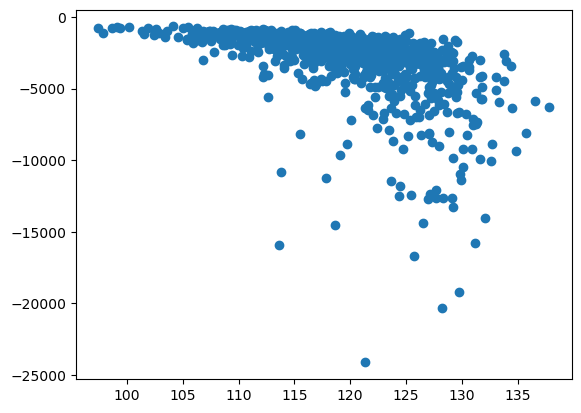

PyObject <matplotlib.collections.PathCollection object at 0x7fc5eb4d2390>

In [72]:
#Test Likelihood
obs[(:k,1)] = 10
scores = []
accs = []
for i = 1:1000
    (trace,) = generate(classifier, (xt,), obs)
    push!(scores,get_score(trace))
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_acc = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
end

scatter(accs,scores)
#plt.ylim(-2000,0)

In [ ]:
include("NUTS.jl")
(best_trace,) = generate(classifier, (xt,), obs)
l = best_trace[:l]
param_selection = select()
for i=1:l+1 #Number of Layers
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end
traces = NUTS(best_trace, param_selection, 0.65, 100, 3, true);

In [ ]:
#Straight NUTS
include("NUTS.jl")
Δ_max = 10000

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        β₂ = trace[(:k,1)]
        
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

m=3
iters=1000

(best_trace,) = generate(classifier, (xt,), obs)
best_k = best_trace[(:k,1)]
println("Starting ks: $best_k")
traces = []
push!(traces,best_trace)

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:1
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            println("Accepted")
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

for i=1:iters
    
    trace_star = traces[i]
    if i%10 == 0
        println("Iteration $i: $(get_score(trace_star))")
        flush(stdout)
    end
    trace_star = gibbs_hyperparameters(trace_star)
    trace_star, accepted = nuts_parameters(trace_star)

    push!(traces,trace_star)
end

In [59]:
#-------------
#Run Inference
#-------------

include("NUTS.jl")
Δ_max = 1000
acc_prob = 0.65
#Random.seed!(1)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []

#Inference Hyperparameters
iters = 1
m = 3

@gen function gibbs_hyperparameters(trace)
    obs_new = choicemap()::ChoiceMap
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    
    for i=1:trace[:l] + 1
        #Biases
        bias = trace[(:b,i)]
        
        n = length(bias)
        α = α₁ + (n/2)
        
        Σ = sum(bias.^2)/2 
        β = 1/(1/β₁ + Σ)
        
        τᵦ ~ gamma(α,β)
        
        #Weights
        β₂ = trace[(:k,1)]
        
        i == 1 ? α₀ = α₁ : α₀ = α₂
        i == 1 ? β₀ = β₁ : β₀ = β₂
        
        weight = trace[(:W,i)]
        
        n = length(weight)
        α = α₀ + (n/2)
        
        Σ = sum(weight.^2)/2
        β = 1/(1/β₀ + Σ)
        
        τ ~ gamma(α,β)
        
        obs_new[(:τ,i)] = τ
        obs_new[(:τᵦ,i)] = τᵦ
    end
    
    (new_trace,_,_,_) = update(trace, args, argdiffs, obs_new)
    
    return new_trace
end

function nuts_parameters(trace)
    
    l = trace[:l]
    param_selection = select()
    for i=1:l+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:1
        new_trace = NUTS(trace, param_selection, 0.65, m, m, false)[m+1]
        new_score = get_score(new_trace)
        if prev_score != new_score
            #println("Accepted")
            return (new_trace, 1)
        else
            return (trace, 0)
        end
    end
    
    return (trace, acc)
end

function node_parameter(trace)
    obs = obs_master
    for i=1:trace[:l]+1
        obs[(:τ,i)] = trace[(:τ,i)]
        obs[(:τᵦ,i)] = trace[(:τᵦ,i)]
    end
    
    init_trace = trace
    
    #################################################RJNUTS#################################################
    #NUTS Step 1
    trace_tilde = trace
    for i=1:1
        trace_tilde = gibbs_hyperparameters(trace_tilde)
        (trace_tilde,) = nuts_parameters(trace_tilde)
    end
    
    #Reversible Jump Step
    (trace_prime, q_weight) = node_change(trace_tilde)
    
    #NUTS Step 2
    trace_star = trace_prime
    for i=1:1
        (trace_star,) = nuts_parameters(trace_star)
        trace_star = gibbs_hyperparameters(trace_star)
    end
    #################################################RJNUTS#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight

    if rand() < exp(across_score)
        println("********** Accepted: $(trace_star[(:k,1)]) **********")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

(trace,) = generate(classifier, (xt,), obs)
#trace = best_trace
starting_k = trace[(:k,1)]
println("Starting k: $starting_k")
traces = []

for i=1:300
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    trace  = gibbs_hyperparameters(trace)
    (trace, accepted) = nuts_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    println("$i : $(get_score(trace))")
    flush(stdout)
    if i%10 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

Starting k: 2
Inf warning
Inf warning
1 : -1308.7711272236575
********** Accepted: 1 **********
2 : -452.4234088458555
3 : -440.881201860685
4 : -414.16126758965777
5 : -355.8574803570678
6 : -361.7038760335364
7 : -352.8507044139585
8 : -352.7331197748669
9 : -349.6593974535038
10 : -344.6105919963152
Epoch 10 A Acceptance Probability: 10.0 %
Epoch 10 W Acceptance Probability: 100.0 %
11 : -341.5161275458883
12 : -334.4620016792572
13 : -334.0235068055941
14 : -329.5243931139648
15 : -329.80188416982
16 : -321.85281535123
17 : -327.81685449930484
18 : -330.8908044660596
19 : -329.98388171622094


InterruptException: InterruptException:

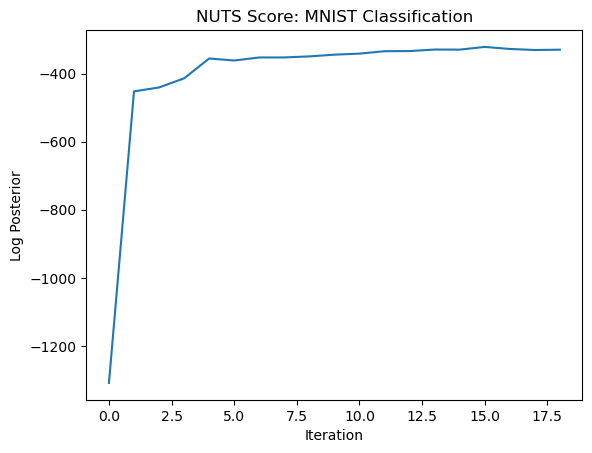

In [60]:
#Log Posterior Score Chart
obs_master = choicemap()::ChoiceMap
for i=1:length(y)
    obs_master[(:y,i)] = y[i]
end
obs = obs_master;

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: MNIST Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

In [67]:
#Plot Training Accuracy
accs = []
dists = []
for i = 1:length(traces)
    trace = traces[i]
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    test_acc = sum([y[i] == results[i] for i=1:length(y)])/length(y)
    test_dist = sum([euclidean(yt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
    push!(dists,test_dist)
end

plot(accs)
plt.title("NUTS Accuracy: MNIST Training Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Accuracy");

DimensionMismatch: DimensionMismatch("new dimensions (2, 50) must be consistent with array size 160")

In [ ]:
#Plot Testing Accuracy
accs = []
#dists = []
for i = 1:length(traces)
    trace = traces[i]
    test_labels = G(xz,trace)
    results = label_output(test_labels)
    test_acc = sum([y_test[i] == results[i] for i=1:length(y_test)])/length(y_test)
    test_dist = sum([euclidean(yzt[:,j],test_labels[:,j]) for j=1:length(y)])
    push!(accs,test_acc)
    #push!(dists,test_dist)
end

plot(accs)
plt.title("NUTS Accuracy: MNIST Test Set Classification")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

In [ ]:
plot(dists)

In [ ]:
y[1]
targets = []
for i=1:length(traces)
    trace = traces[i]
    test_labels = G(xt,trace)
    results = label_output(test_labels)
    push!(targets,results[46])
end
hist(targets)
println(targets)

In [ ]:
#Marginalize Probabilities
j = 100
targets = zeros(length(traces)-j,c,N)
for i=j:length(traces)-j
    trace = traces[i]
    labels = G(xt,trace)
    targets[i-j+1,:,:] = labels
end

sums = sum(targets,dims=1)[1,:,:]./(length(traces)-j)
guesses = [findmax(sums[:,i])[2] for i=1:N]
test_acc = sum([y[i] == guesses[i] for i=1:length(y)])